# ILAMB Introduction with a Watershed Emphasis

What is the International Land Model Benchmarking (ILAMB) effort?

* *Community*: global group of modelers and scientists enthusiastic about benchmarking
* *Datasets*: curated collection of datasets formatted for easy comparison
* *Methods*: innovative assembly of techniques for benchmarking models
* *Software*: open-source python package which you can use or tailor
* *Results*: catalog of comparisons which you can access and peruse

Our group's focus is on global/decadal scale comparisons to improve carbon-cycle understanding.

## Resources

* Github for the ILAMB [codebase](https://github.com/rubisco-sfa/ILAMB)
* Github for dataset [development](https://github.com/rubisco-sfa/ILAMB-Data)
* Sample [output](https://www.ilamb.org/CMIP5v6/historical/) which presents a comparison of CMIP5 and CMIP6 models
* Detailed [tutorials](https://www.ilamb.org/doc/tutorial.html) which cover basic operation
* Our methodology [paper](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018MS001354)

## Basic Flow

* Create a [configure](https://github.com/rubisco-sfa/ILAMB/blob/master/src/ILAMB/data/sample.cfg) file which sets up all the reference datasets you wish to be part of the comparison
* Execute `ilamb-run` on this configure file and pointing to model result files
* Internally, ILAMB will look at the observational files and try to pull out a commensurate quantity from the models automatically
* ILAMB has many metrics and plots which it computes automatically based on appropriateness of the data, and then generates a hierarchy of webpage that organizes and sythesizes this information

None of this requires a user to know much of anything about python and programming. If a reference dataset can be encoded, ILAMB can be used to benchmark performance relative to that standard. 

ILAMB was written to be extensible, but this will require better understanding of how it works.

## The ILAMB.Variable

The basic object inside the package is the Variable. Underneath the hood we are using numpy arrays and provide functions which compute the various integrals/means using the property area weighting.

In [1]:
from ILAMB.Variable import Variable
from ILAMB.Regions import Regions
import matplotlib.pyplot as plt
import os

In [2]:
# Linear Optimal Runoff Aggregate (LORA)
v = Variable(filename = os.path.join(os.environ['ILAMB_ROOT'],'DATA/runoff/LORA/LORA.nc'),
            variable_name = "mrro")
print(v)

Variable: mrro
--------------
                unit: kg m-2 s-1
          isTemporal: True (396)
           isSpatial: True (360,720)
           isLayered: False
          nDatasites: N/A
           dataShape: (396, 360, 720)
             dataMax: 1.137024e-03
             dataMin: 0.000000e+00
            dataMean: 9.271038e-06



In [3]:
# Integrals and conversions
vmap = v.integrateInTime(mean=True).convert('mm d-1')
print(vmap)

Variable: mrro_integrated_over_time_and_divided_by_time_period
--------------------------------------------------------------
                unit: mm d-1
          isTemporal: False
           isSpatial: True (360,720)
           isLayered: False
          nDatasites: N/A
           dataShape: (360, 720)
             dataMax: 1.713648e+01
             dataMin: 0.000000e+00
            dataMean: 8.036318e-01



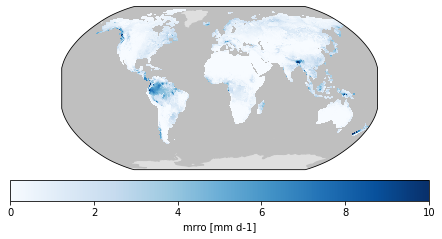

In [4]:
# Plotting uses cartopy/matplotlib internally
vmap.plot(None,
          cmap="Blues",
          cbar=True,
          vmin=0,vmax=10,
          label="mrro [%s]" % (vmap.unit))
plt.show()

In [5]:
vcrv = v.integrateInSpace(mean=True).convert("mm d-1")
print(vcrv)

Variable: mrro_integrated_over_space_and_divided_by_area
--------------------------------------------------------
                unit: mm d-1
          isTemporal: True (396)
           isSpatial: False
           isLayered: False
          nDatasites: N/A
           dataShape: (396,)
             dataMax: 1.268306e+00
             dataMin: 5.173747e-01
            dataMean: 8.171514e-01



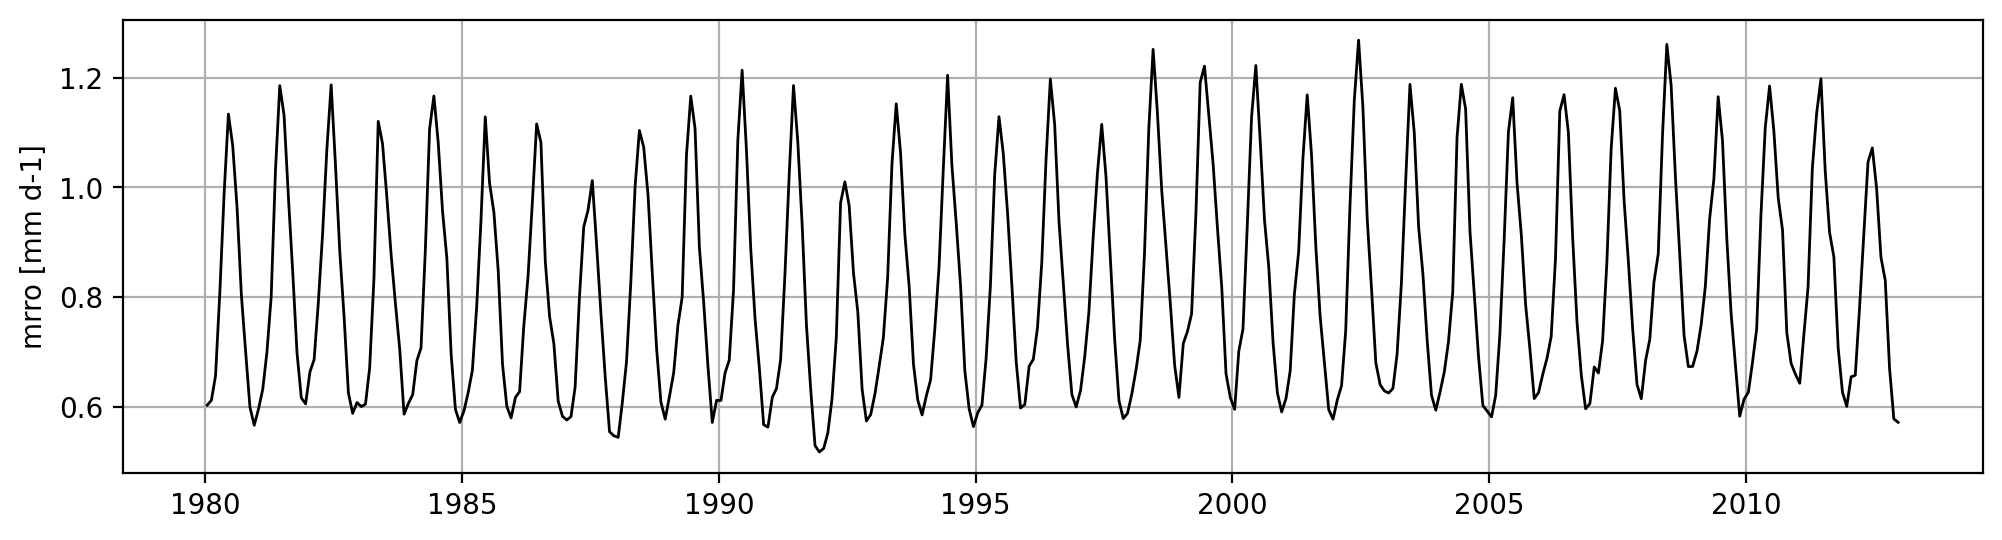

In [6]:
fig,ax = plt.subplots(figsize=(12,3),dpi=200)
vcrv.plot(ax)
ax.set_ylabel('mrro [%s]' % vcrv.unit)
plt.show()

## Regions

ILAMB also has a way of standardizing regions which can be added as lat/lon bounds, netCDF paint-by-the-numbers type grid, or even by shapefiles (in development). All of the plotting and integrals understand these region keywords. For example, we can define a USA region by bounds:

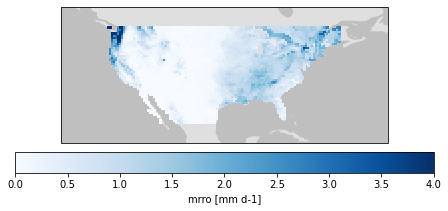

In [7]:
ilamb_regions = Regions()
ilamb_regions.addRegionLatLonBounds("usa","USA",[24.6,49],[-125.2,-66.4])
vmap.plot(None,
          region='usa',
          cmap="Blues",
          cbar=True,
          vmin=0,vmax=4,
          label="mrro [%s]" % (vmap.unit))
plt.show()

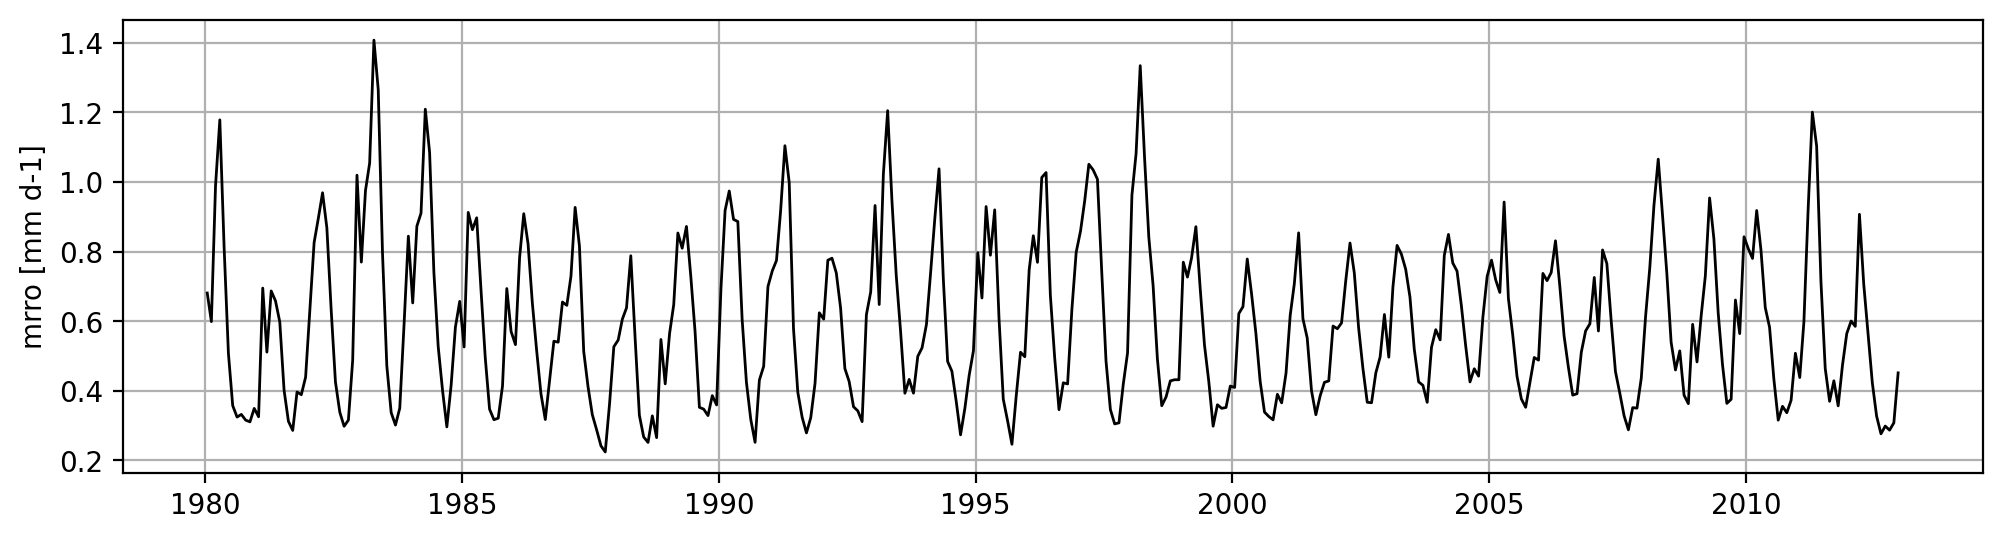

In [8]:
# the region keyword is also accepted by spatial integrals
vusa = v.integrateInSpace(region='usa',mean=True).convert('mm d-1')
fig,ax = plt.subplots(figsize=(12,3),dpi=200)
vusa.plot(ax)
ax.set_ylabel('mrro [%s]' % vusa.unit)
plt.show()

We can also set a region by a netCDF mask. We have a set of the world's 50 largest river basins as part of the ILAMB data which we will load here and repeat the above plots for the amazon river basin.

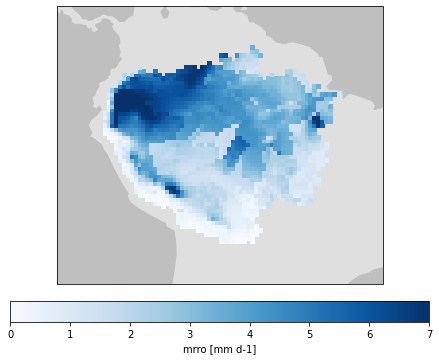

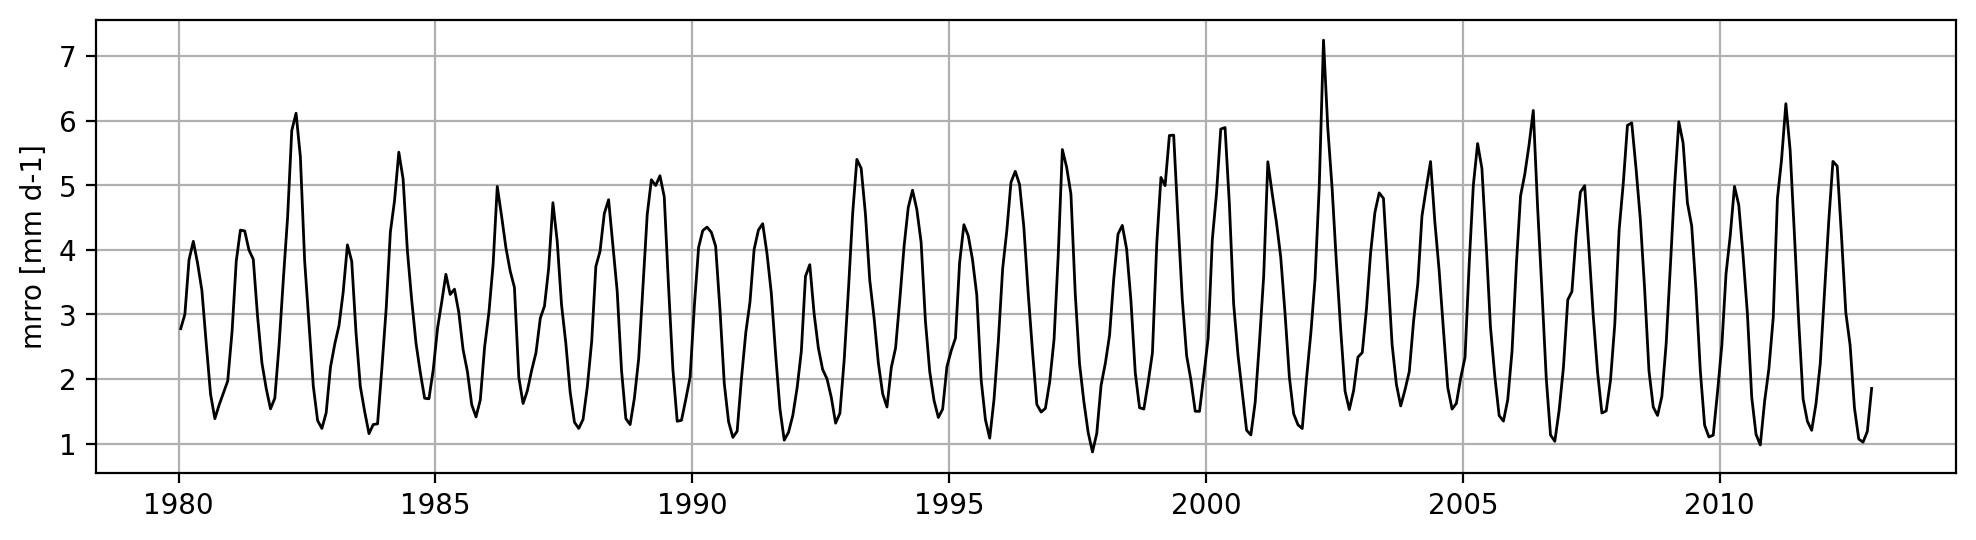

In [9]:
ilamb_regions.addRegionNetCDF4(os.path.join(os.environ['ILAMB_ROOT'],'DATA/runoff/Dai/basins_0.5x0.5.nc'))

# map
vmap.plot(None,
          region='amazon',
          cmap="Blues",
          cbar=True,
          vmin=0,vmax=7,
          label="mrro [%s]" % (vmap.unit))

# integrals
vamazon = v.integrateInSpace(region='amazon',mean=True).convert('mm d-1')
fig,ax = plt.subplots(figsize=(12,3),dpi=200)
vamazon.plot(ax)
ax.set_ylabel('mrro [%s]' % vusa.unit)
plt.show()

## Other applications

We are working to add more functionality and metrics associated with watersheds with InterFACE.

* models - we have to learn what formats common models of interest use and make sure we can get them into memory as a ILAMB Variable
* grids - ILAMB is designed to use a regular lat/lon grid but only because our focus until now has been CMIP-style models. This is less a problem if we are mostly interested in integrated quantities over basins
